In [390]:
# Calcular zero point de cda imagen y actualizar el header con ZP
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.background import Background2D, MedianBackground



def calibrate_photometry(image_path, reference_stars, aperture_radius=3.0):
    """
    Realiza la calibración fotométrica usando estrellas de referencia.

    Params:
    - image_path: Ruta a la imagen FITS.
    - reference_stars: Lista de diccionarios con 'ra', 'dec', y 'magnitude' para cada estrella de referencia.
    - aperture_radius: Radio de la apertura para medir el flujo.

    Returns:
    - ZeroPoint promedio calculado.
    """
    im=Image(image_path)
    bkg = Background2D(im.data, (50, 50), filter_size=(3, 3), bkg_estimator=MedianBackground())
    image_data_subtracted = im.data - bkg.background
    
    zero_points = []

    for ra,dec, known_magnitude in ref_stars[(ref_stars["object"]==im.object)&(ref_stars["i_mag"]<17)][["ra", "dec", "i_mag"]].values:
        sky_coord = SkyCoord(ra, dec, unit=(u.deg, u.deg), frame='icrs')
        x_pixel, y_pixel = im.sky_to_pixel(sky_coord.ra.deg, sky_coord.dec.deg)
        aperture = CircularAperture((x_pixel, y_pixel), r=aperture_radius)
        phot_table = aperture_photometry(image_data_subtracted, aperture)
        flux = phot_table['aperture_sum'][0]
        
        if flux > 0:
            zero_point = known_magnitude + 2.5 * np.log10(flux)
            zero_points.append(zero_point)

    if zero_points:
        average_zero_point = np.mean(zero_points)
    else:
        average_zero_point = np.nan

    return average_zero_point

files = n.astrometry_files["i"]
for file in files:
    im=Image(file)
    print(f"Processing file: {file}")
    av_zp = calibrate_photometry(file, ref_stars, aperture_radius=5.0)
    print(f"Average ZeroPoint: {av_zp}")
    im.update_header("ZP", av_zp)

Processing file: ../data_hsh0/20240315/astrometry/OGLE-BLG-0002i0016.fit
Average ZeroPoint: 24.535433245245763
Processing file: ../data_hsh0/20240315/astrometry/OGLE-BLG-0009i0002.fit
Average ZeroPoint: 24.710692008184985
Processing file: ../data_hsh0/20240315/astrometry/OGLE-BLG-0009i0004.fit
Average ZeroPoint: 25.070718621100042
Processing file: ../data_hsh0/20240315/astrometry/OGLE-BLG-0010i0002.fit
Average ZeroPoint: 25.505129437282285
Processing file: ../data_hsh0/20240315/astrometry/OGLE-BLG-0002i0008.fit
Average ZeroPoint: 24.612946682363663
Processing file: ../data_hsh0/20240315/astrometry/OGLE-BLG-0010i0023.fit
Average ZeroPoint: 24.990344488491466
Processing file: ../data_hsh0/20240315/astrometry/OGLE-GD-0006i0006.fit
Average ZeroPoint: 25.591000849123876
Processing file: ../data_hsh0/20240315/astrometry/OGLE-GD-0001i0006.fit
Average ZeroPoint: 25.020906709289818
Processing file: ../data_hsh0/20240315/astrometry/OGLE-BLG-0010i0019.fit
Average ZeroPoint: 24.76923882574908
Proc

In [393]:
def loc_mag(image_path, ra,dec,aperture=3.0):
    im=Image(image_path)
    x,y = im.sky_to_pixel(ra, dec)
    Aperture = CircularAperture((x, y), r=aperture)
    phot = aperture_photometry(im.data, Aperture)
    flux = phot['aperture_sum'][0]
    return -2.5 * np.log10(flux) + im.header["ZP"]

for file in files:
    im = Image(file)
    print(file)
    x,y = im.sky_to_pixel(im.object_coord[0], im.object_coord[1])
    roi = {"x":x,"y":y, "d":50}
    sources = get_sources(im.data, im.wcs,  roi)
    ra_s, dec_s = closest_source(im.object_coord[0], im.object_coord[1], sources)
    mag_s = loc_mag(file, ra_s,dec_s,aperture=5)
    mag_o = loc_mag(file, im.object_coord[0], im.object_coord[1],aperture=5)
    print(f"Object: {mag_o}    -     Nearest source: {mag_s}")


../data_hsh0/20240315/astrometry/OGLE-BLG-0002i0016.fit
Object: 11.865492170278712    -     Nearest source: 11.865241622222769
../data_hsh0/20240315/astrometry/OGLE-BLG-0009i0002.fit
Object: 11.789106598027587    -     Nearest source: 11.787849579385835
../data_hsh0/20240315/astrometry/OGLE-BLG-0009i0004.fit
Object: 12.175505550813076    -     Nearest source: 12.174026103325698
../data_hsh0/20240315/astrometry/OGLE-BLG-0010i0002.fit
Object: 12.510615908853941    -     Nearest source: 12.436216984908953
../data_hsh0/20240315/astrometry/OGLE-BLG-0002i0008.fit
Object: 11.94497282197231    -     Nearest source: 11.98995515459167
../data_hsh0/20240315/astrometry/OGLE-BLG-0010i0023.fit
Object: 12.497138967019147    -     Nearest source: 12.393105770602684
../data_hsh0/20240315/astrometry/OGLE-GD-0006i0006.fit
Object: 12.658416153686439    -     Nearest source: 12.624289681485088
../data_hsh0/20240315/astrometry/OGLE-GD-0001i0006.fit
Object: 12.173855797504217    -     Nearest source: 12.1707

In [404]:
from astropy.stats import mad_std
import numpy as np
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astropy.io import fits

def background_noise(data, aperture):
    mask = aperture.to_mask(method='center')
    aperture_data = mask.multiply(data)
    return mad_std(aperture_data)

def loc_mag(image_path, ra, dec, aperture=3.0):
    im = Image(image_path)
    x, y = im.sky_to_pixel(ra, dec)
    Aperture = CircularAperture((x, y), r=aperture)
    phot = aperture_photometry(im.data, Aperture)
    flux = phot['aperture_sum'][0]
    header = im.header
    gain = header["GAIN"]
    rdnoise = header["RDNOISE"]
    bgd_noise = background_noise(im.data, Aperture)
    poisson_error = np.sqrt(flux / gain)
    total_error = np.sqrt(poisson_error**2 + (rdnoise**2 + bgd_noise**2) * Aperture.area)
    mag = -2.5 * np.log10(flux) + header["ZP"]
    mag_error = 2.5 / np.log(10) * total_error / flux

    return mag, mag_error, poisson_error, total_error

for file in files:
    im = Image(file)
    print("\n"+file)
    x, y = im.sky_to_pixel(im.object_coord[0], im.object_coord[1])
    roi = {"x": x, "y": y, "d": 50}
    sources = get_sources(im.data, im.wcs, roi)
    ra_s, dec_s = closest_source(im.object_coord[0], im.object_coord[1], sources)
    mag_s, mag_s_error, poisson_s_error, total_s_error = loc_mag(file, ra_s, dec_s, aperture=5)
    mag_o, mag_o_error, poisson_o_error, total_o_error = loc_mag(file, im.object_coord[0], im.object_coord[1], aperture=5)
    print(f"Object: {mag_o} ± {mag_o_error} (Poisson error: {poisson_o_error}, Total error: {total_o_error})")
    print(f"Nearest source: {mag_s} ± {mag_s_error} (Poisson error: {poisson_s_error}, Total error: {total_s_error})")



../data_hsh0/20240315/astrometry/OGLE-BLG-0002i0016.fit
Object: 11.865492170278712 ± 0.007232956190703635 (Poisson error: 230.55623665357086, Total error: 779.0546868147862)
Nearest source: 11.865241622222769 ± 0.007122505315812806 (Poisson error: 230.58284014587795, Total error: 767.3351827077043)

../data_hsh0/20240315/astrometry/OGLE-BLG-0009i0002.fit
Object: 11.789106598027587 ± 0.00571603080074734 (Poisson error: 258.88431675729055, Total error: 776.254988992185)
Nearest source: 11.787849579385835 ± 0.005508847960794883 (Poisson error: 259.0342227008279, Total error: 748.98554812361)

../data_hsh0/20240315/astrometry/OGLE-BLG-0009i0004.fit
Object: 12.175505550813076 ± 0.005082142578122521 (Poisson error: 255.75920519921544, Total error: 673.6088014039764)
Nearest source: 12.174026103325698 ± 0.004720248349782689 (Poisson error: 255.93351606731292, Total error: 626.4948946035195)

../data_hsh0/20240315/astrometry/OGLE-BLG-0010i0002.fit
Object: 12.510615908853941 ± 0.01541606475856

In [407]:
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import numpy as np
from astropy.io import fits
from astropy.stats import mad_std

def loc_mag(image_path, ra, dec, aperture=3.0, annulus_r_in=6.0, annulus_r_out=8.0):
    im = Image(image_path)
    x, y = im.sky_to_pixel(ra, dec)
    Aperture = CircularAperture((x, y), r=aperture)
    Annulus = CircularAnnulus((x, y), r_in=annulus_r_in, r_out=annulus_r_out)
    phot_aperture = aperture_photometry(im.data, Aperture)
    flux = phot_aperture['aperture_sum'][0]
    phot_annulus = aperture_photometry(im.data, Annulus)
    bkg_mean = phot_annulus['aperture_sum'][0] / Annulus.area
    bkg_total = bkg_mean * Aperture.area
    flux_net = flux - bkg_total
    gain = im.header["GAIN"]
    rdnoise = im.header["RDNOISE"]
    poisson_error = np.sqrt(flux_net / gain)
    total_error = np.sqrt(poisson_error**2 + (rdnoise**2 + bkg_mean**2) * Aperture.area)
    mag = -2.5 * np.log10(flux_net) + im.header["ZP"]
    mag_error = 2.5 / np.log(10) * total_error / flux_net
    return mag, mag_error, poisson_error, total_error
    
for file in files:
    im = Image(file)
    print("\n"+file)
    x, y = im.sky_to_pixel(im.object_coord[0], im.object_coord[1])
    roi = {"x": x, "y": y, "d": 50}
    sources = get_sources(im.data, im.wcs, roi)
    ra_s, dec_s = closest_source(im.object_coord[0], im.object_coord[1], sources)
    mag_s, mag_s_error, poisson_s_error, total_s_error = loc_mag(file, ra_s, dec_s, aperture=3)
    mag_o, mag_o_error, poisson_o_error, total_o_error = loc_mag(file, im.object_coord[0], im.object_coord[1], aperture=4)
    print(f"Object: {mag_o} ± {mag_o_error} (Poisson error: {poisson_o_error}, Total error: {total_o_error})")
    print(f"Nearest source: {mag_s} ± {mag_s_error} (Poisson error: {poisson_s_error}, Total error: {total_s_error})")


../data_hsh0/20240315/astrometry/OGLE-BLG-0002i0016.fit
Object: 16.538000321714442 ± 7.138784498948708 (Poisson error: 26.808668486495822, Total error: 10396.163987864584)
Nearest source: 17.126285680664225 ± 9.187842806446522 (Poisson error: 20.446462131495903, Total error: 7783.022073576651)

../data_hsh0/20240315/astrometry/OGLE-BLG-0009i0002.fit
Object: 17.376220625622988 ± 16.657036997090557 (Poisson error: 19.755268473266916, Total error: 13172.311227414544)
Nearest source: 17.70713711621373 ± 16.97954326433237 (Poisson error: 16.96288188276735, Total error: 9899.73662598986)

../data_hsh0/20240315/astrometry/OGLE-BLG-0009i0004.fit
Object: 17.374368284007907 ± 11.638219239526064 (Poisson error: 23.337736229896525, Total error: 12844.06068969124)
Nearest source: 17.609264598430762 ± 10.824168981234514 (Poisson error: 20.944956567458675, Total error: 9621.700909035562)

../data_hsh0/20240315/astrometry/OGLE-BLG-0010i0002.fit
Object: 16.647541434966193 ± 4.2865772183581266 (Poisson

/tmp/ipykernel_593850/1937844488.py:19: RuntimeWarning: invalid value encountered in sqrt
  poisson_error = np.sqrt(flux_net / gain)
/tmp/ipykernel_593850/1937844488.py:21: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux_net) + im.header["ZP"]


Object: 17.046872867577534 ± 12.730144201541961 (Poisson error: 20.081286632761618, Total error: 10401.949818990832)
Nearest source: nan ± nan (Poisson error: nan, Total error: nan)

../data_hsh0/20240315/astrometry/OGLE-GD-0001i0002.fit
Object: 16.49768829535674 ± 5.16637686919123 (Poisson error: 34.83619044085627, Total error: 12704.154193175997)
Nearest source: 17.13353716093573 ± 6.996065592227295 (Poisson error: 25.993267904464105, Total error: 9577.98162088155)

../data_hsh0/20240315/astrometry/OGLE-BLG-0002i0010.fit
Object: 16.19417975073897 ± 4.884393847491486 (Poisson error: 32.15727736068216, Total error: 10234.522365012814)
Nearest source: 16.6754532855352 ± 5.706461614801741 (Poisson error: 25.764668828844798, Total error: 7675.63633787621)

../data_hsh0/20240315/astrometry/OGLE-GD-0006i0004.fit
Object: 16.290270522164064 ± 2.7501418805084246 (Poisson error: 47.652764453173056, Total error: 12654.053346066743)
Nearest source: 16.701241406410322 ± 2.976257047157065 (Poisson 

/tmp/ipykernel_593850/1937844488.py:19: RuntimeWarning: invalid value encountered in sqrt
  poisson_error = np.sqrt(flux_net / gain)
/tmp/ipykernel_593850/1937844488.py:21: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux_net) + im.header["ZP"]


Object: nan ± nan (Poisson error: nan, Total error: nan)
Nearest source: 18.067900828898313 ± 19.50959704395756 (Poisson error: 11.952580088216825, Total error: 5647.678746600917)

../data_hsh0/20240315/astrometry/OGLE-BLG-0010i0006.fit
Object: 16.520811328409536 ± 3.725267138476875 (Poisson error: 43.10842750653106, Total error: 14027.49570730212)
Nearest source: 15.891792447097142 ± 1.5622123056647237 (Poisson error: 57.59250349951359, Total error: 10499.541393129995)

../data_hsh0/20240315/astrometry/OGLE-BLG-0002i0012.fit
Object: 16.234601043147375 ± 4.804763756029609 (Poisson error: 32.5015596371409, Total error: 10284.396294640166)
Nearest source: 16.907462993692448 ± 6.718696786355327 (Poisson error: 23.841403154709624, Total error: 7738.326077332993)

../data_hsh0/20240315/astrometry/OGLE-BLG-0002i0004.fit


/tmp/ipykernel_593850/1937844488.py:19: RuntimeWarning: invalid value encountered in sqrt
  poisson_error = np.sqrt(flux_net / gain)
/tmp/ipykernel_593850/1937844488.py:21: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux_net) + im.header["ZP"]


Object: 16.93283565260475 ± 11.422767839799146 (Poisson error: 21.399336428246414, Total error: 10599.132566475046)
Nearest source: nan ± nan (Poisson error: nan, Total error: nan)

../data_hsh0/20240315/astrometry/OGLE-BLG-0009i0006.fit
Object: 18.281534471729245 ± 33.95791804263149 (Poisson error: 13.884985562113314, Total error: 13265.703361358383)
Nearest source: 18.231537744918704 ± 24.34301033990872 (Poisson error: 14.20838700646744, Total error: 9957.772503939013)


In [195]:
from astroquery.mast import Catalogs
from astropy.coordinates import SkyCoord
import astropy.units as u
for file in files:
    im = Image(file)
    print(file)
    print(im.object, im.object_coord)
    ra, dec = im.object_coord
    coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
    try:
        catalog_data = Catalogs.query_region(coord, radius=3*u.deg, catalog="Panstarrs")
        print(len(catalog_data))
        reference_stars = []
        max_mag_error = 5; max_mag = 15
        for star in catalog_data:
            if (star['iMeanPSFMagErr'] <= max_mag_error) and (star["iMeanPSFMag"]<=15):  # Error en la magnitud i
                reference_stars.append({
                    'ra': star['raMean'],
                    'dec': star['decMean'],
                    'i_mag': star['iMeanPSFMag'],  # Magnitud en banda i
                    'i_mag_err': star['iMeanPSFMagErr']
                })
        print(len(reference_stars))
    except Exception as e:
        print(e)

../data_hsh0/20240315/astrometry/OGLE-BLG-0002i0016.fit
OGLE-BLG-0002 (np.float64(276.25079166666666), np.float64(-21.02872222222222))
504 Server Error: Gateway Time-out for url: https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean.json
../data_hsh0/20240315/astrometry/OGLE-BLG-0009i0002.fit
OGLE-BLG-0009 (np.float64(258.2805833333333), np.float64(-32.92155555555555))
84218
724
../data_hsh0/20240315/astrometry/OGLE-BLG-0009i0004.fit
OGLE-BLG-0009 (np.float64(258.2805833333333), np.float64(-32.92155555555555))
84218
724
../data_hsh0/20240315/astrometry/OGLE-BLG-0010i0002.fit
OGLE-BLG-0010 (np.float64(259.5230833333333), np.float64(-31.682805555555557))
504 Server Error: Gateway Time-out for url: https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean.json
../data_hsh0/20240315/astrometry/OGLE-BLG-0002i0008.fit
OGLE-BLG-0002 (np.float64(276.25079166666666), np.float64(-21.02872222222222))
504 Server Error: Gateway Time-out for url: https://catalogs.mast.stsci.edu/api/v0.1/pans

KeyboardInterrupt: 

In [175]:
catalog_data.columns

<TableColumns names=('ra','dec','err_maj','err_min','err_ang','designation','j_m','j_cmsig','j_msigcom','j_snr','h_m','h_cmsig','h_msigcom','h_snr','k_m','k_cmsig','k_msigcom','k_snr','ph_qual','rd_flg','bl_flg','cc_flg','ndet','prox','pxpa','pxcntr','gal_contam','mp_flg','cntr','hemis','xdate','scan','glon','glat','x','y','z','x_scan','jdate','j_psfchi','h_psfchi','k_psfchi','j_m_stdap','j_msig_stdap','h_m_stdap','h_msig_stdap','k_m_stdap','k_msig_stdap','dist_edge_ns','dist_edge_ew','dist_edge_flg','dup_src','use_src','a','dist_opt','phi_opt','b_m_opt','vr_m_opt','nopt_mchs','ext_key','scan_key','coadd_key','coadd','htm20')>

Coordenadas del objeto en píxeles: x=442.4791540696494, y=574.9765547545451
442.4791540696494 574.9765547545451


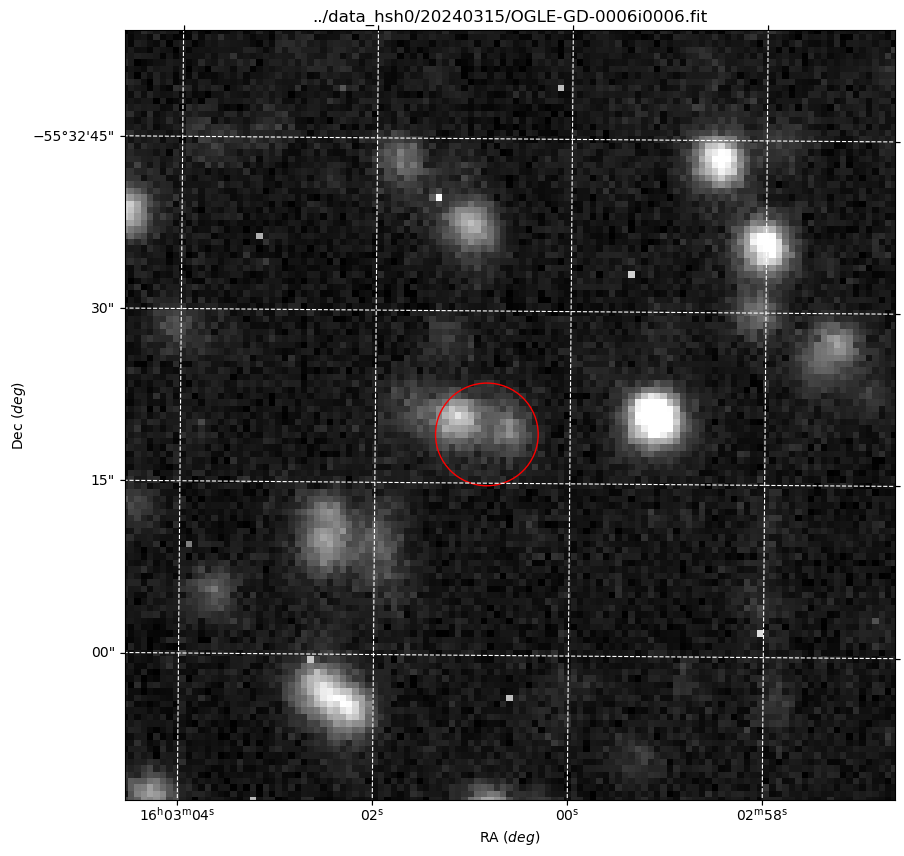

Fuente más cercana a RA=240.7535595606437, Dec=-55.53868056494279
Flujo instrumental: 414503.28125
Magnitud: 14.10012435913086


np.float32(14.956181)

In [147]:
def flux_in_circle(image_data, centroid, radius=5):
    x_center, y_center = centroid
    y, x = np.indices(image_data.shape)
    mask = (x - x_center)**2 + (y - y_center)**2 <= radius**2
    return np.sum(image_data[mask])

def flux_to_mag(flux, zp=29.0):
    return -2.5 * np.log10(flux) + zp

# calib = calibration[calibration["file"] == fit_file]

image_data = get_data(fit_file)
wcs=compute_wcs(calib)
x,y = wcs.all_world2pix(ra_s, dec_s, 1)
radius = 8
flux = flux_in_circle(image_data, (x, y), radius)
magnitude = flux_to_mag(flux*head["GAIN"])

plot_image_with_loc(fit_file, ra_s, dec_s, wcs, radius, roi)

print(f"Fuente más cercana a RA={ra_s}, Dec={dec_s}")
print(f"Flujo instrumental: {flux}")
print(f"Magnitud: {magnitude}")
flux_to_mag(flux)

Substracción del perfil de estrella vecina (not tested) 

In [144]:
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.background import MMMBackground

def flux_to_mag_error(image, x,y , aperture, an_in, an_out):
    aperture = CircularAperture((x,y), r=aperture)
    annulus = CircularAnnulus((x,y), r_in=an_in, r_out=an_out)
    phot_table = aperture_photometry(image, aperture)
    annulus_masks = annulus.to_mask(method='exact')
    annulus_data = annulus_masks.multiply(image)
    annulus_data_1d = annulus_data[annulus_data > 0]
    bkg_median = np.median(annulus_data_1d)
    bkg_std = np.std(annulus_data_1d)

    flux_source = phot_table['aperture_sum'] - (bkg_median * aperture.area)
    snr = flux_source / np.sqrt(flux_source + (aperture.area * bkg_std**2))
    error_mag = 1.0857 / snr
    return error_mag

image_data = get_data(fit_file)
mag_error = flux_to_mag_error(image_data, x,y, aperture=5, an_in=7, an_out=10)
mag_error


0.28561691220803165


# Automatization
Loop {nights}:
1. collect_files: bias, dark, flat, science
2. If not science images: skip night
3. If there isn't bias, dark or flat
    - Search in contigous night folder
    - If there isn't → skip night
4. Create master images
5. Calibrate science images
6. Astrometry: get wcs
7. Locate
    - Object
    - Detect sources
    - Closest source to object
8. Is any other source intersecting the object of interest?
    - No → Compute flux as sum of aperture - background
    - Yes: Fit profile model of close star → Compute flux as difference of profiles and background
9. Compute error magnitude
10. Save values

In [ ]:
# Correct object names in header to match with the name on Objects.csv

root = "../data_hsh0/"
 
for night in [root+nig+"/" for nig in os.listdir(root) if nig.startswith("2024")]:
    print(night)
    bias_files, dark_files, flat_files, science_files = collect_files(night)
    for band, files in science_files.items():
        for file in files:
            head = get_head(file)
            obj.append(head["OBJECT"])
            print(file,"                 ", head["OBJECT"])

## Plots para el poster

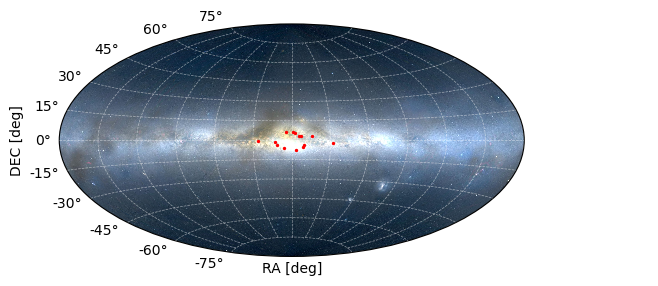

In [133]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from mw_plot import MWSkyMap
import matplotlib.pyplot as plt

# Diccionario de objetos
objects = {'OGLE-GD-0006': ('16:03:00.62', '-55:32:21'), 'OGLE-GD-0001': ('16:47:10.74', '-39:53:57'),
           'OGLE-BLG-0009': ('17:13:07.34', '-32:55:17.6'), 'OGLE-BLG-0010': ('17:18:05.54', '-31:40:58.1'),
           'OGLE-BLG-0034': ('17:44:10.4', '-39:06:47.6'), 'OGLE-BLG-0002': ('18:25:00.19', '-21:01:43.4'),
           'OGLE-DG-0016': ('18:42:39.87', '-06:06:25.4'), 'OGLE-BLG-0300': ('17:34:52.9', '-39:10:08.3'),
           'OGLE-BLG-0013': ('17:20:33.36', '-26:13:44'), 'OGLE-BLG-0592': ('18:23:54.34', '-26:39:09.8'),
           'OGLE-BLG-0605': ('17:19:27.76', '-28:13:39.9'), 'OGLE-BLG-0257': ('18:09:08.11', '-35:37:44.7'),
           'OGLE-BLG-0669': ('18:20:21.39', '-18:16:09.8'), 'OGLE-BLG-0674': ('17:30:56.62', '-21:49:42.4')}

ra_list = [coord[0] for coord in objects.values()]
dec_list = [coord[1] for coord in objects.values()]
object_labels = [key[-4:] for key in objects.keys()]  # Últimos 4 números de cada objeto

sky_coords = SkyCoord(ra=ra_list, dec=dec_list, unit=(u.hourangle, u.deg))
mw1 = MWSkyMap(background="Mellinger color optical survey", grid="galactic", projection="aitoff")
mw1.scatter(sky_coords.ra, sky_coords.dec, s=(2 * u.deg).to_value(u.deg))
for i, (ra, dec) in enumerate(zip(sky_coords.ra, sky_coords.dec)):
    plt.text(ra.to(u.rad).value, dec.to(u.rad).value, object_labels[i], fontsize=10, ha='right', color='white')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.savefig("../sky_map_bkg.png")
plt.show()


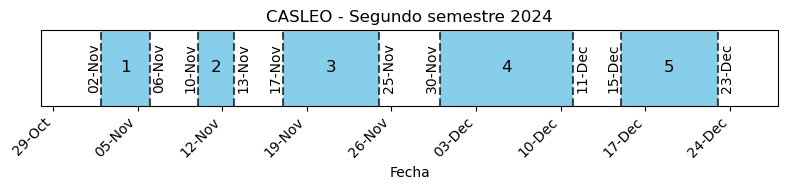

In [192]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

start_dates = ['2024-11-02', '2024-11-10', '2024-11-17', 
               '2024-11-30', '2024-12-15']
end_dates = ['2024-11-06', '2024-11-13', '2024-11-25', 
             '2024-12-11', '2024-12-23']
labels = np.arange(1, len(start_dates)+1)
colors = ['skyblue']*(len(start_dates)+1)

start_dates = [datetime.strptime(date, '%Y-%m-%d') for date in start_dates]
end_dates = [datetime.strptime(date, '%Y-%m-%d') for date in end_dates]

fig, ax = plt.subplots(figsize=(8, 2))

for i, (start, end, label, color) in enumerate(zip(start_dates, end_dates, labels, colors)):
    ax.barh(1, (end - start).days, left=start, height=0.4, color=color, label=label)
    ax.text(start + (end - start) / 2, 1, label, va='center', ha='center', color='black', fontsize=12)

for start, end in zip(start_dates, end_dates):
    ax.axvline(x=start, color='black', linestyle='--', alpha=0.7)
    ax.axvline(x=end, color='black', linestyle='--', alpha=0.7)
    ax.text(start-timedelta(1.2), 1, start.strftime('%d-%b'), rotation=90, verticalalignment='center', fontsize=10)
    ax.text(end+timedelta(0.2), 1, end.strftime('%d-%b'), rotation=90, verticalalignment='center', fontsize=10)


ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))


ax.set_xlim([min(start_dates) - timedelta(days=5), max(end_dates) + timedelta(days=5)])
ax.set_ylim(0.9, 1.1)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.get_yaxis().set_visible(False)
ax.set_xlabel('Fecha')
ax.set_title('CASLEO - Segundo semestre 2024')
plt.tight_layout()
plt.savefig("../Temporadas_Semeste2.png")


#### Season 1

In [14]:
OBJECTS = {"OBJECT":[], "EXPTIME":[], "NIGHT":[], "MJD-OBS":[], 
           "FILTER":[], "RDNOISE":[], "AIRMASS":[], "RA":[], "DEC":[], "CAMTEM":[]}
main_folder ="../Imagenes/data_hsh"
for night in os.listdir(main_folder):
    if night.startswith("2024"):
        print(night)
        night_path = os.path.join(main_folder, night)
        for i, image in enumerate(os.listdir(night_path)):
            if image.endswith(".fit") and not any(word in image.lower() for word in ["flat", "bias", "set","foco", "Set", "focus", "point", "dark"]):
                im =Image(os.path.join(night_path, image))
                # im.correct_dates_header()
                im =Image(os.path.join(night_path, image))
                OBJECTS["NIGHT"].append(night)
                for key, item in OBJECTS.items():
                    if key != "NIGHT":
                        try:
                            OBJECTS[key].append(im.header[key])
                        except Exception as e:
                            OBJECTS[key].append(input(f"Insert {key} for {im.path} image:"))


20240313
'Gaia2023cnu'
'Gaia2023cnu'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'Gaia2023cnu'
'Gaia2023cnu'
'Gaia2023cnu'
'Gaia2023cnu'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'Gaia2023cnu'
'Gaia2023cnu'
'Gaia2023cnu'
'Gaia2023cnu'
'galaxia'
'galaxia'
'Gaia2023cnu'
'Gaia2023cnu'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'Gaia2023cnu'
'Gaia2023cnu'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'Gaia2023cnu'
'Gaia2023cnu'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'Gaia2023cnu'
'Gaia2023cnu'
'Gaia2023cnu'
'Gaia2023cnu'
'Gaia2023cnu'
'Gaia2023cnu'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0011'
'Gaia2023cnu'
'Gaia2023cnu'
'OGLE-2023-GD-0011'
'OGLE-2023-GD-0

Insert OBJECT for ../Imagenes/data_hsh/20240316/OGLE-BLG-002i0007.fit image: OGLE-2024-BLG-0002


'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0009'
'OGLE-GD-0009'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0009'
'OGLE-GD-0009'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0009'
'OGLE-GD-0009'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0009'
'OGLE-GD-0009'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0009'
'OGLE-GD-0009'
'OGLE-GD-0002'
'OGLE-GD-0002'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0009'
'OGLE-GD-0009'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0009'
'OGLE-GD-0009'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0010'
'OGLE-GD-0

In [313]:
objects

{'OGLE-GD-0006': ('16:03:00.62', '-55:32:21'),
 'OGLE-GD-0001': ('16:47:10.74', '-39:53:57'),
 'OGLE-BLG-0009': ('17:13:07.34', '-32:55:17.6'),
 'OGLE-BLG-0010': ('17:18:05.54', '-31:40:58.1'),
 'OGLE-BLG-0034': ('17:44:10.4', '-39:06:47.6'),
 'OGLE-BLG-0002': ('18:25:00.19', '-21:01:43.4'),
 'OGLE-DG-0016': ('18:42:39.87', '-06:06:25.4'),
 'OGLE-BLG-0300': ('17:34:52.9', '-39:10:08.3'),
 'OGLE-BLG-0013': ('17:20:33.36', '-26:13:44'),
 'OGLE-BLG-0592': ('18:23:54.34', '-26:39:09.8'),
 'OGLE-BLG-0605': ('17:19:27.76', '-28:13:39.9'),
 'OGLE-BLG-0257': ('18:09:08.11', '-35:37:44.7'),
 'OGLE-BLG-0669': ('18:20:21.39', '-18:16:09.8'),
 'OGLE-BLG-0674': ('17:30:56.62', '-21:49:42.4')}

In [33]:
# Temp 1
df = pd.DataFrame(OBJECTS)
# for key, item in OBJECTS.items():
#     print(key+ "        "+str(len(OBJECTS[key])))

df.loc[df["OBJECT"].str.contains("BLG-0010", na=False), "OBJECT"] = "OGLE-2024-BLG-0010"
df.loc[df["OBJECT"].str.contains("BLG-0002", na=False), "OBJECT"] = "OGLE-2024-BLG-0002"
df.loc[df["OBJECT"].str.contains("BLG-0034", na=False), "OBJECT"] = "OGLE-2024-BLG-0034"
df.loc[df["OBJECT"].str.contains("BLG-0006", na=False), "OBJECT"] = "OGLE-2024-BLG-0006"
df.loc[df["OBJECT"].str.contains("BLG-0009", na=False), "OBJECT"] = "OGLE-2024-BLG-0009"
df.loc[df["OBJECT"].str.contains("GD-0001", na=False), "OBJECT"] = "OGLE-2024-GD-0001"
df.loc[df["OBJECT"].str.contains("GD-0010", na=False), "OBJECT"] = "OGLE-2024-BLG-0010"
df.loc[df["OBJECT"].str.contains("GD-0009", na=False), "OBJECT"] = "OGLE-2024-BLG-0009"
df.loc[df["OBJECT"].str.contains("0011", na=False), "OBJECT"] = "OGLE-2023-GD-0019"
df.loc[df["OBJECT"].str.contains("GD-0002", na=False), "OBJECT"] = "OGLE-2024-BLG-0002"
df.loc[df["OBJECT"].str.contains("GD-0006", na=False), "OBJECT"] = "OGLE-2024-BLG-0006"
df.loc[df["OBJECT"].str.contains("Gaia23cnu", na=False), "OBJECT"] = "Gaia2023cnu"
df.loc[df["OBJECT"].str.contains("Gaia23dpn", na=False), "OBJECT"] = "Gaia2023dpn"
df.loc[df["OBJECT"].str.contains("OGLE-2024-GD-006", na=False), "OBJECT"] = "OGLE-2024-BLG-0006"
for key, item in df["OBJECT"].value_counts().items(): 
   if item < 13:
        df = df[df["OBJECT"]!=key]
df = df[df["FILTER"]=="(5) I"]
df = df[df["EXPTIME"]!=600.0]
df["OBJECT"].value_counts()

# df[df["OBJECT"]=="OGLE-2024-BLG-0009"]["RA"]


OBJECT
OGLE-2023-GD-0019     194
OGLE-2024-BLG-0010     86
Gaia2023cnu            81
OGLE-2024-BLG-0006     45
OGLE-2024-BLG-0002     44
OGLE-2024-BLG-0009     28
OGLE-2024-GD-0001      22
Gaia2023dpn            13
OGLE-2024-BLG-0034     10
Name: count, dtype: int64

In [12]:
# Temp 2
df = pd.DataFrame(OBJECTS)
# for key, item in OBJECTS.items():
#     print(key+ "        "+str(len(OBJECTS[key])))
df.loc[df["OBJECT"].isin(["OGLE-2024-GD-006", "OGLE-2024-GD-0006", "OGLE-2024-DG-0006", "OGLE2024-GD-0006", "OGLE-2024-DG-006"]), "OBJECT"] = "OGLE-2024-GD-0006"
df.loc[df["OBJECT"].isin(["OGLE-2024-GD-0016", "OGLE-2024-DG-0016", "OGLE2024-DG-0016"]), "OBJECT"] = "OGLE-2024-DG-0016"
df.loc[df["DEC"]=="-21:51:51.2", "OBJECT"] = "FLAG"
df.loc[df["OBJECT"].isin(["OGLE2024-BLG-0674", "OGLE-2024-BLG-0674", "OGLE-2024-BGL-0674"]), "OBJECT"] = "OGLE-2024-BGL-0674"
df.loc[df["OBJECT"].isin(["OGLE2024-BLG-0592", "OGLE-2024-BLG-0592"]), "OBJECT"] = "OGLE-2024-BGL-0592"
for key, item in df["OBJECT"].value_counts().items(): 
   if item < 13:
        df = df[df["OBJECT"]!=key]
for key, item in df["EXPTIME"].value_counts().items(): 
   if item < 13:
        df = df[df["EXPTIME"]!=key]
df = df[df["OBJECT"]!="TOI3071"]
df = df[df["FILTER"]=="(3) V"]
df = df[df["EXPTIME"]!=180.0]
from datetime import datetime
print(df["FILTER"].value_counts())


FILTER
(3) V    1443
Name: count, dtype: int64


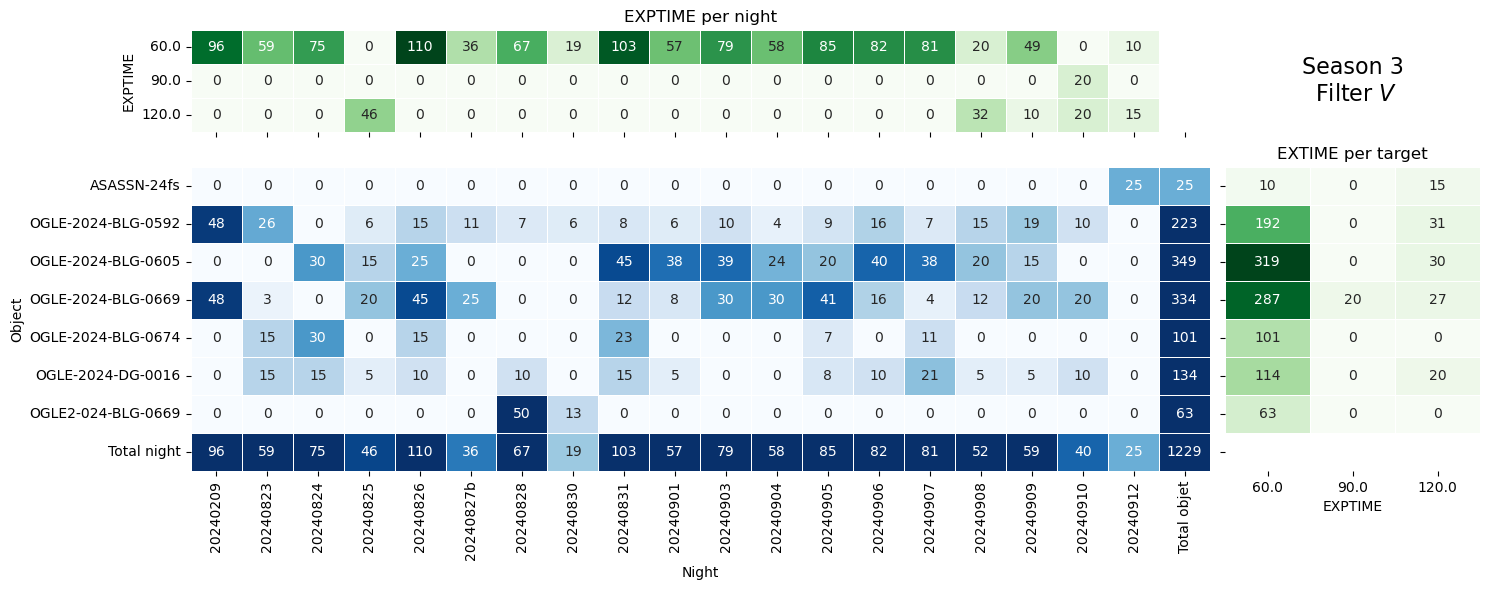

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
season = 3
band = "V"
heatmap_data = pd.crosstab(df["OBJECT"], df["NIGHT"])
vmin = np.min(heatmap_data)
vmax = np.max(heatmap_data)

heatmap_data["Total objet"] = heatmap_data.sum(axis=1)
heatmap_data.loc["Total night"] = heatmap_data.sum(axis=0)

heatmap_data_obj = df.groupby(['OBJECT', 'EXPTIME']).size().unstack(fill_value=0)
heatmap_data_night = df.groupby(['NIGHT', 'EXPTIME']).size().unstack(fill_value=0)

# Crear la figura y los ejes para los histogramas y el mapa de calor
fig = plt.figure(figsize=(15,6))

gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1,3))

ax_heatmap  = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_heatmap)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_heatmap)
text = fig.add_subplot(gs[0, 1])

text.set_xticklabels([])
text.set_yticklabels([])
text.set_xticks([])  # Eliminar ticks x
text.set_yticks([])  # Eliminar ticks y
text.spines['top'].set_visible(False)  # Eliminar el borde superior
text.spines['right'].set_visible(False)  # Eliminar el borde derecho
text.spines['bottom'].set_visible(False)  # Eliminar el borde inferior
text.spines['left'].set_visible(False)  # Eliminar el borde izquierdo
text.text(0.5, 0.5, f'Season {season}\n Filter ${band}$', ha='center', va='center', fontsize=16) 
# Crear el mapa de calor

plt.setp(ax_histy.get_yticklabels(), visible=False)

sns.heatmap(heatmap_data_obj, annot=True, fmt="d", cmap="Greens", ax=ax_histy, linewidths=.5,  cbar=False)
ax_histy.set_yticks([])
ax_histy.set_yticklabels([])
ax_histy.set_title('EXTIME per target')
ax_histy.set_ylabel('')
ax_histy.set_xlabel('EXPTIME')
plt.setp(ax_histy.get_yticklabels(), visible=False)
plt.setp(ax_histx.get_xticklabels(), visible=False)


ax_histx.set_xticks([])
ax_histx.set_xticklabels([])

sns.heatmap(heatmap_data_night.T, annot=True, fmt="d", cmap="Greens", ax=ax_histx, linewidths=.5,  cbar=False)
ax_histx.set_title('EXPTIME per night')
ax_histx.set_xlabel('')
ax_histx.set_ylabel('EXPTIME')



sns.heatmap(heatmap_data, annot=True, fmt="d", vmin=vmin, vmax=vmax, cmap="Blues", cbar=False, ax=ax_heatmap, linewidths=.5)

ax_heatmap.set_ylabel('Object')
ax_heatmap.set_xlabel('Night')
# Ajustar la presentación
plt.tight_layout()
# plt.show()
plt.savefig(f"../Season{season}-{band}.png")


### Season 3

In [66]:
OBJECTS = {"OBJECT":[], "EXPTIME":[], "NIGHT":[], "MJD-OBS":[], 
           "FILTER":[], "RDNOISE":[], "AIRMASS":[], "RA":[], "DEC":[], "CAMTEM":[]}
import os
for night in os.listdir("../Imagenes/Tercera_Temporada1"):
    if night.startswith("2024") and not "." in night:
        print( "----------------", night)
        night_path = os.path.join("../Imagenes/Tercera_Temporada1", night)
        for i, image in enumerate(os.listdir(night_path)):
            if image.endswith(".fit") and not any(word in image.lower() for word in ["flat", "bias", "set", "Set", "point", "dark"]):
                im =Image(os.path.join(night_path, image))
                im.correct_dates_header()
                im =Image(os.path.join(night_path, image))
                OBJECTS["NIGHT"].append(night)
                for key, item in OBJECTS.items():
                    if key != "NIGHT":
                        try:
                            OBJECTS[key].append(im.header[key])
                        except Exception as e:
                            OBJECTS[key].append(input(f"Insert {key} for {im.path} image:"))




---------------- 20240909
---------------- 20240911
---------------- 20240903
---------------- 20240829
---------------- 20240905
'OGLE-2024-BLG-0605'
'OGLE-2024-BLG-0605'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0592'
'OGLE-2024-BLG-0592'
'OGLE-2024-DG-0016'
'OGLE-2024-DG-0016'
'OGLE-2024-DG-0016'
'OGLE-2024-DG-0016'
'OGLE-2024-BLG-0592'
'OGLE-2024-BLG-0592'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0605'
'OGLE-2024-BLG-0605'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-DG-0016'
'OGLE-2024-DG-0016'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0605'
'OGLE-2024-BLG-0605'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0605'
'OGLE-2024-BLG-0605'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-0669'
'OGLE-2024-BLG-

Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240827b/OGLE2024-BLG-05920001.fit image: OGLE-2024-BLG-0592


'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0592'
'OGLE2024-BLG-0592'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0592'
'OGLE2024-BLG-0592'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0592'
'OGLE2024-BLG-0592'
'OGLE2024-BLG-0592'
'OGLE2024-BLG-0592'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0592'
'OGLE2024-BLG-0592'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0592'
'OGLE2024-BLG-0592'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'
'OGLE2024-BLG-0669'


'?GLE-2024-DG-0016'
'?GLE-2024-BLG-0592'
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240823/OGLE-2024-BLG-0592v0009.fit
'?GLE-2024-BLG-0592'
'?GLE-2024-BLG-0669'
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240823/OGLE-2024-BLG-0669i0009.fit
'?GLE-2024-BLG-0669'
'?GLE-2024-BLG-0674'
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240823/OGLE-2024-BLG-0674v0012.fit
'?GLE-2024-BLG-0674'
'?GLE-2024-BLG-0674'
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240823/OGLE-2024-BLG-0674i0003.fit
'?GLE-2024-BLG-0674'
'?GLE-2024-DG-0016'
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240823/OGLE-2024-DG-0016v0003.fit
'?GLE-2024-DG-0016'
'?GLE-2024-BLG-0669'
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240823/OGLE-2024-BLG-0669i0006.fit
'?GLE-2024-BLG-0669'
'?GLE-2024-BLG-0592'
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240823/OGLE-2024-BLG-0592v0023.fit
'?GLE-2024-BLG-0592'
'?GLE-2024-BLG-0669'
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240823/OGLE-202

Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920008.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0015.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592i0004.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669v0005.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669v0021.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0027.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592i0028.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669v0015.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669i0024.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0013.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0018.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669i0002.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0021.fit
Couldn't load OBJECT name. E

Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920020.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016v0004.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016i0003.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016v0002.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669v0009.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0011.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669i0004.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669i0018.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920014.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920014.fit image: OGLE-2024-BLG-0592


Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920019.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920019.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669v0011.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669v0007.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0002.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0016.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0020.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0019.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669v0023.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0005.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669v0013.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592i0010.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669i0016.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Tempora

Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920003.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592i0006.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0015.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016i0002.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0013.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669v0001.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0001.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0018.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0014.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669i0008.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920005.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920005.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0011.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0019.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592i0012.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0025.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920012.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920012.fit image: OGLE-2024-BLG-0592


Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920006.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920006.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0003.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0015.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920004.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920004.fit image: OGLE-2024-BLG-0592


Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920016.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920016.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0023.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0003.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0011.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0003.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016i0011.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920011.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920011.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0005.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016i0007.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0007.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669v0017.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920015.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920015.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0017.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592i0026.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592i0016.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016v0001.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0004.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016i0001.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669i0022.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0029.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016i0009.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592i0008.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0009.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1

Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920007.fit image: OGLE-2024-BLG-0592


Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920010.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920010.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0010.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0012.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0012.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669i0020.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016v0003.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0017.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016i0008.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0019.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920001.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920001.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016v0005.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0016.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669i0014.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592i0018.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0010.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0017.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0009.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920018.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920018.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0002.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0006.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592i0024.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0007.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920013.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920013.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0013.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0001.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0007.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0006.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669i0012.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920002.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920002.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016i0005.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920009.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920009.fit image: OGLE-2024-BLG-0592


Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920017.fit
Couldn't load OBJECT name. Error: "Keyword 'OBJECT' not found."


Insert OBJECT for ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-05920017.fit image: OGLE-2024-BLG-0592


Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592i0020.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016i0006.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0008.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0005.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592v0001.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605v0008.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-DG-0016i0010.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592i0022.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669i0010.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0592i0014.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0605i0004.fit
Correcting MJD... ../Imagenes/Tercera_Temporada1/20240908/OGLE-BLG-0669v0003.fit
---------------- 20240907
Corr

In [85]:
# Temp 2
df = pd.DataFrame(OBJECTS)
# for key, item in OBJECTS.items():
#     print(key+ "        "+str(len(OBJECTS[key])))
df.loc[df["OBJECT"].isin(["OGLE-BLG-0669", "OGLE2024-BLG-0669", "OGLE2024BLG0669", "OGLE-2024-BLG0669", "?GLE-2024-BLG-0669"]), "OBJECT"] = "OGLE-2024-BLG-0669"
df.loc[df["OBJECT"].isin(["OGLE-BLG-0605" , "?GLE-2024-BLG-0605"]), "OBJECT"] = "OGLE-2024-BLG-0605"
df.loc[df["OBJECT"].isin(["OGLE-BLG-0592" , "OGLE2-024-BLG-0592", "OGLE2024BLG0592", "OGLE2024-BLG-0592", "?GLE-2024-BLG-0592"]), "OBJECT"] = "OGLE-2024-BLG-0592"
df.loc[df["OBJECT"].isin(["OGLE-DG-0016" , "?GLE-2024-DG-0016", "OGLE2-024-DG-0016", "OGLE2024DG0016"]), "OBJECT"] = "OGLE-2024-DG-0016"
df.loc[df["OBJECT"].isin(["?GLE-2024-BLG-0674","OGLE-BLG-0674"]), "OBJECT"] = "OGLE-2024-BLG-0674"
# df.loc[df["DEC"]=="-21:51:51.2", "OBJECT"] = "FLAG"

# for key, item in df["OBJECT"].value_counts().items(): 
#    if item < 13:
#         df = df[df["OBJECT"]!=key]
# for key, item in df["EXPTIME"].value_counts().items(): 
#    if item < 13:
#         df = df[df["EXPTIME"]!=key]
df = df[df["OBJECT"]!="OGLE"]
df = df[df["FILTER"]=="(3) V"]
df = df[df["EXPTIME"]!=30.0]
df = df[df["EXPTIME"]!=0.0]
from datetime import datetime
df["EXPTIME"].value_counts()



EXPTIME
60.0     1086
120.0     123
90.0       20
Name: count, dtype: int64